**Chennai House Price Prediction**

**Problem Statement**

Real estate transactions are quite opaque sometimes and it
may be difficult for a newbie to know the fair price of any given
home. Thus, multiple real estate websites have the functionality
to predict the prices of houses given different features
regarding it. Such forecasting models will help buyers to identify
a fair price for the home and also give insights to sellers as to
how to build homes that fetch them more money. Chennai
house sale price data is shared here and the participants are
expected to build a sale price prediction model that will aid the
customers to find a fair price for their homes and also help the
sellers understand what factors are fetching more money
for the houses?

**Data**

The historical sale data is available here.

**Minimum Requirements**

It is not sufficient to just fit a model - the model must be
analysed to find the important factors that contribute towards
the price. Also, it will be better to give a forecast range (range
of permissible values) rather than a single estimate as it will
help the customers to negotiate

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_style('dark')
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from scipy.stats import pearsonr
from scipy import stats
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
url="/train-chennai-sale.csv"
df = pd.read_csv(url)
print(df.columns)
print('The total number of features:',df.shape[1])

Index(['PRT_ID', 'AREA', 'INT_SQFT', 'DATE_SALE', 'DIST_MAINROAD', 'N_BEDROOM',
       'N_BATHROOM', 'N_ROOM', 'SALE_COND', 'PARK_FACIL', 'DATE_BUILD',
       'BUILDTYPE', 'UTILITY_AVAIL', 'STREET', 'MZZONE', 'QS_ROOMS',
       'QS_BATHROOM', 'QS_BEDROOM', 'QS_OVERALL', 'REG_FEE', 'COMMIS',
       'SALES_PRICE'],
      dtype='object')
The total number of features: 22


Dropping unwanted features

In [3]:
df=df.drop(['PRT_ID','REG_FEE','COMMIS'],axis=1)

In [4]:
print("Total number of features in the data is:",df.shape[1])
pd.DataFrame(df.dtypes.value_counts()).T

Total number of features in the data is: 19


,object,float64,int64
0,9,6,4


In [5]:
categorical_features = [x for x in df.columns 
                if not (df[x].dtype == np.float64 
                        or df[x].dtype == np.int64)]
print(categorical_features)

['AREA', 'DATE_SALE', 'SALE_COND', 'PARK_FACIL', 'DATE_BUILD', 'BUILDTYPE', 'UTILITY_AVAIL', 'STREET', 'MZZONE']


In [6]:
numerical_features=[x for x in df.columns if df[x].dtype==np.int64 or df[x].dtype==np.float64]
print(numerical_features)

['INT_SQFT', 'DIST_MAINROAD', 'N_BEDROOM', 'N_BATHROOM', 'N_ROOM', 'QS_ROOMS', 'QS_BATHROOM', 'QS_BEDROOM', 'QS_OVERALL', 'SALES_PRICE']


In [7]:
print('The data has {} categorical features'.format(len(categorical_features)))
print('The data has {} numerical_features'.format(len(numerical_features)))

The data has 9 categorical features
The data has 10 numerical_features


In [8]:
pd.DataFrame(df.isnull().sum()).T

,AREA,INT_SQFT,DATE_SALE,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,SALE_COND,PARK_FACIL,DATE_BUILD,BUILDTYPE,UTILITY_AVAIL,STREET,MZZONE,QS_ROOMS,QS_BATHROOM,QS_BEDROOM,QS_OVERALL,SALES_PRICE
0,0,0,0,0,1,5,0,0,0,0,0,0,0,0,0,0,0,48,0


Filling the null values

In [9]:
df['N_BEDROOM']=df['N_BEDROOM'].fillna(df['N_BEDROOM'].mean())
df['N_BATHROOM']=df['N_BATHROOM'].fillna(df['N_BATHROOM'].mean())
df['QS_OVERALL']=df['QS_OVERALL'].fillna(df['QS_OVERALL'].mean())

df['N_BEDROOM'] = np.floor(df['N_BEDROOM'])
df['N_BATHROOM'] = np.floor(df['N_BATHROOM'])

In [10]:
pd.DataFrame(df.isnull().sum()).T

,AREA,INT_SQFT,DATE_SALE,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,SALE_COND,PARK_FACIL,DATE_BUILD,BUILDTYPE,UTILITY_AVAIL,STREET,MZZONE,QS_ROOMS,QS_BATHROOM,QS_BEDROOM,QS_OVERALL,SALES_PRICE
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Spelling correction

In [11]:
df['PARK_FACIL'].replace(['Noo'],['No'],inplace=True)
df['STREET'].replace(['Pavd','NoAccess'],['Paved','No Access'],inplace=True)
df['UTILITY_AVAIL'].replace(['NoSewr ','NoSeWa','All Pub'],['No Sewer','No Sewer','AllPub'],inplace=True)
df['BUILDTYPE'].replace(['Comercial','Other'],['Commercial','Others'],inplace=True)
df['SALE_COND'].replace(['Ab Normal','Partiall','PartiaLl','Adj Land'],['AbNormal','Partial','Partial','AdjLand'],inplace=True)
df['AREA'].replace(['Ana Nagar','Ann Nagar','Karapakam','Chrompt','Chrmpet','Chormpet','Adyr','Velchery','KKNagar','TNagar'],
['Anna Nagar','Anna Nagar','Karapakkam','Chrompet','Chrompet','Chrompet','Adyar','Velachery','KK Nagar','T Nagar'],
inplace=True)

In [12]:
# pd.DataFrame(df.isnull().sum()).T
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7109 entries, 0 to 7108
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AREA           7109 non-null   object 
 1   INT_SQFT       7109 non-null   int64  
 2   DATE_SALE      7109 non-null   object 
 3   DIST_MAINROAD  7109 non-null   int64  
 4   N_BEDROOM      7109 non-null   float64
 5   N_BATHROOM     7109 non-null   float64
 6   N_ROOM         7109 non-null   int64  
 7   SALE_COND      7109 non-null   object 
 8   PARK_FACIL     7109 non-null   object 
 9   DATE_BUILD     7109 non-null   object 
 10  BUILDTYPE      7109 non-null   object 
 11  UTILITY_AVAIL  7109 non-null   object 
 12  STREET         7109 non-null   object 
 13  MZZONE         7109 non-null   object 
 14  QS_ROOMS       7109 non-null   float64
 15  QS_BATHROOM    7109 non-null   float64
 16  QS_BEDROOM     7109 non-null   float64
 17  QS_OVERALL     7109 non-null   float64
 18  SALES_PR

CREATING NEW FEATURES FOR DATE_SALE & DATE_BUILD

In [13]:
df['DATE_SALE']=pd.to_datetime(df['DATE_SALE'])
df['DATE_BUILD']=pd.to_datetime(df['DATE_BUILD'])
pd.DataFrame(df.dtypes.value_counts()).T

,object,float64,int64,datetime64[ns]
0,7,6,4,2


In [14]:
df['BUILD_YEAR'] = df['DATE_BUILD'].dt.year
df['SALE_YEAR'] = df['DATE_SALE'].dt.year

In [15]:
df["SOLD_AGE"]=df['SALE_YEAR']-df['BUILD_YEAR']

In [148]:
df.drop(['DATE_SALE','DATE_BUILD'],axis=1,inplace=True)

Data visualisation

In [149]:
A=df['AREA'].groupby(df['AREA']).count()
B=df['AREA'].groupby(df['BUILDTYPE']).count()
C=df['AREA'].groupby(df['UTILITY_AVAIL']).count()
D=df['AREA'].groupby(df['STREET']).count()
E=df['AREA'].groupby(df['MZZONE']).count()
F=df['AREA'].groupby(df['PARK_FACIL']).count()

DISTRIBUTION OF THE DATA

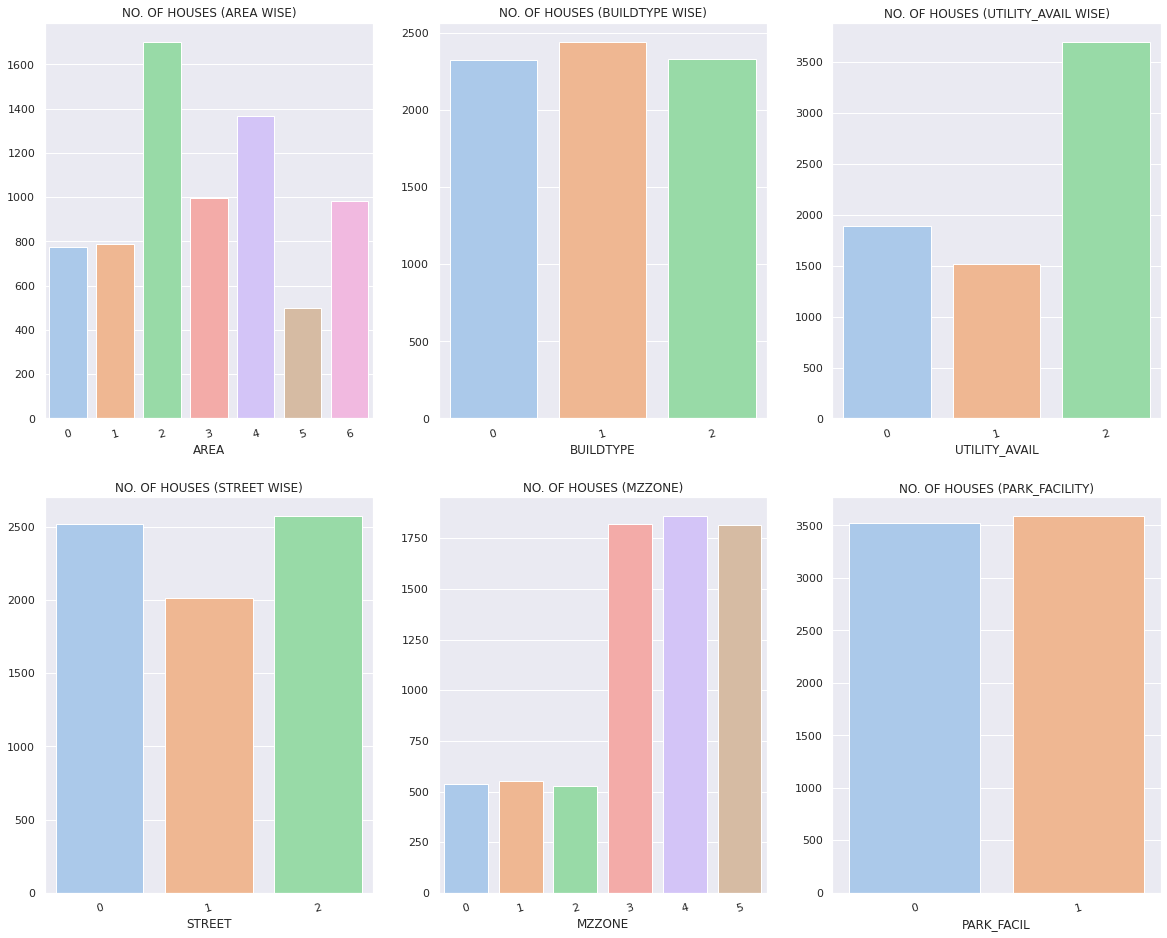

In [150]:
sns.set_theme(style="darkgrid",palette="pastel")
plt.figure(figsize=(20,16))
plt.subplot(231)
sns.barplot(x=A.index,y=A.values,data=df)
plt.xticks(rotation=15)
plt.title('NO. OF HOUSES (AREA WISE)')
plt.subplot(232)
sns.barplot(x=B.index,y=B.values,data=df)
plt.xticks(rotation=15)
plt.title('NO. OF HOUSES (BUILDTYPE WISE)')
plt.subplot(233)
sns.barplot(x=C.index,y=C.values,data=df)
plt.xticks(rotation=15)
plt.title('NO. OF HOUSES (UTILITY_AVAIL WISE)')
plt.subplot(234)
sns.barplot(x=D.index,y=D.values,data=df)
plt.xticks(rotation=15)
plt.title('NO. OF HOUSES (STREET WISE)')
plt.subplot(235)
sns.barplot(x=E.index,y=E.values,data=df)
plt.xticks(rotation=15)
plt.title('NO. OF HOUSES (MZZONE)')
plt.subplot(236)
sns.barplot(x=F.index,y=F.values,data=df)
plt.xticks(rotation=15)
plt.title('NO. OF HOUSES (PARK_FACILITY)')
plt.show()

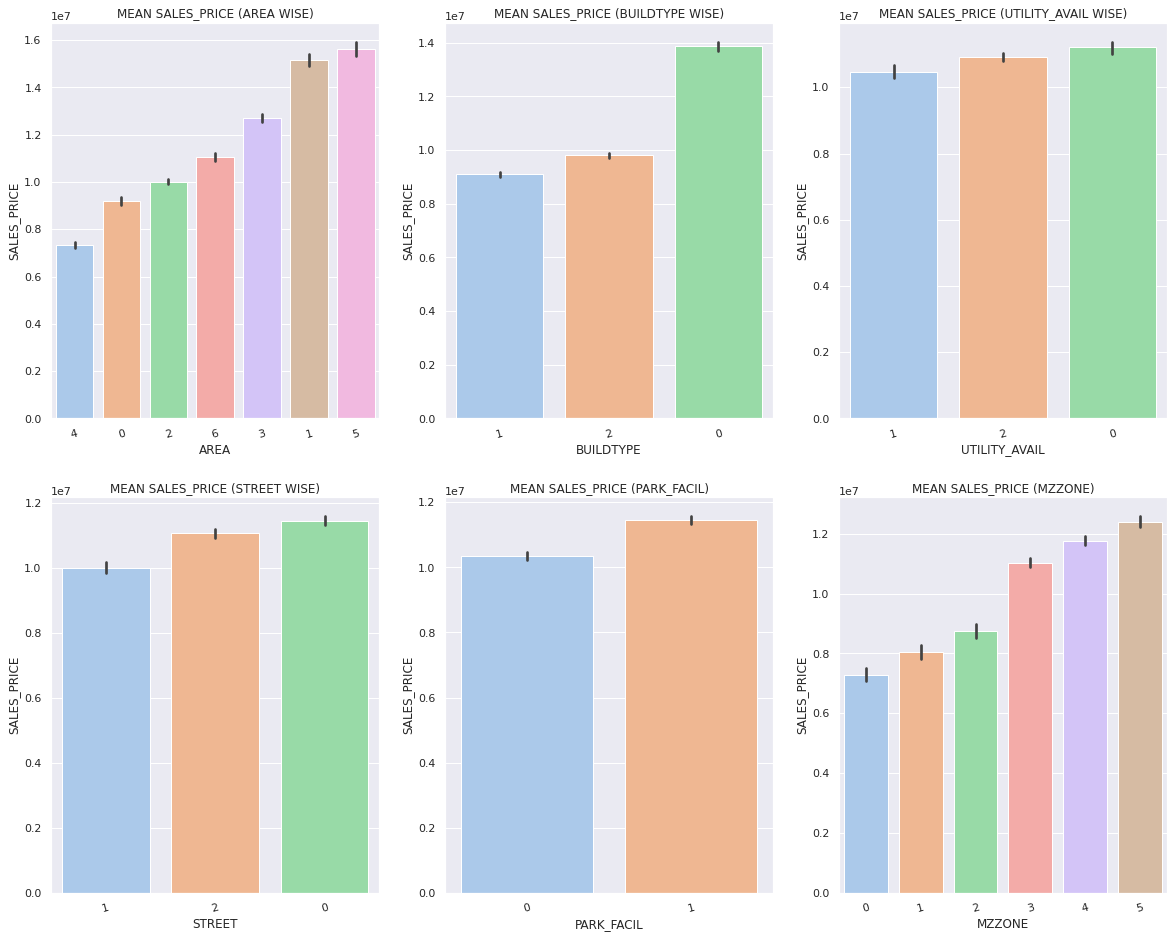

In [151]:
sns.set_theme(style="darkgrid",palette="pastel")
plt.figure(figsize=(20,16))
plt.subplot(231)
sns.barplot(x='AREA',y='SALES_PRICE',data=df,order=df.groupby('AREA')['SALES_PRICE'].mean().reset_index().sort_values('SALES_PRICE')['AREA'])
plt.xticks(rotation=15)
plt.title('MEAN SALES_PRICE (AREA WISE)')
plt.subplot(232)
sns.barplot(x='BUILDTYPE',y='SALES_PRICE',data=df,order=df.groupby('BUILDTYPE')['SALES_PRICE'].mean().reset_index().sort_values('SALES_PRICE')['BUILDTYPE'])
plt.xticks(rotation=15)
plt.title('MEAN SALES_PRICE (BUILDTYPE WISE)')
plt.subplot(233)
sns.barplot(x='UTILITY_AVAIL',y='SALES_PRICE',data=df,order=df.groupby('UTILITY_AVAIL')['SALES_PRICE'].mean().reset_index().sort_values('SALES_PRICE')['UTILITY_AVAIL'])
plt.xticks(rotation=15)
plt.title('MEAN SALES_PRICE (UTILITY_AVAIL WISE)')
plt.subplot(234)
sns.barplot(x='STREET',y='SALES_PRICE',data=df,order=df.groupby('STREET')['SALES_PRICE'].mean().reset_index().sort_values('SALES_PRICE')['STREET'])
plt.xticks(rotation=15)
plt.title('MEAN SALES_PRICE (STREET WISE)')
plt.subplot(235)
sns.barplot(x='PARK_FACIL',y='SALES_PRICE',data=df)
plt.xticks(rotation=15)
plt.title('MEAN SALES_PRICE (PARK_FACIL)')
plt.subplot(236)
sns.barplot(x='MZZONE',y='SALES_PRICE',data=df)
plt.xticks(rotation=15)
plt.title('MEAN SALES_PRICE (MZZONE)')
plt.show()

In [152]:
df.columns

Index(['AREA', 'INT_SQFT', 'DIST_MAINROAD', 'N_BEDROOM', 'N_BATHROOM',
       'N_ROOM', 'SALE_COND', 'PARK_FACIL', 'BUILDTYPE', 'UTILITY_AVAIL',
       'STREET', 'MZZONE', 'QS_ROOMS', 'QS_BATHROOM', 'QS_BEDROOM',
       'QS_OVERALL', 'SALES_PRICE', 'BUILD_YEAR', 'SALE_YEAR', 'SOLD_AGE'],
      dtype='object')

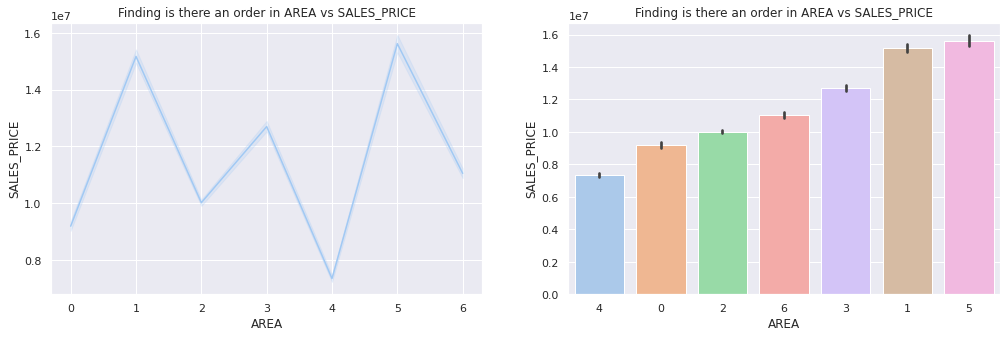

In [153]:
plt.figure(figsize=(17,5))
plt.subplot(121)
sns.lineplot(x=df['AREA'],y=df['SALES_PRICE'])
plt.title('Finding is there an order in AREA vs SALES_PRICE')
plt.subplot(122)
sns.barplot(x='AREA',y='SALES_PRICE',data=df,order=df.groupby('AREA')['SALES_PRICE'].mean().reset_index().sort_values('SALES_PRICE')['AREA'])
plt.title('Finding is there an order in AREA vs SALES_PRICE')
plt.show()

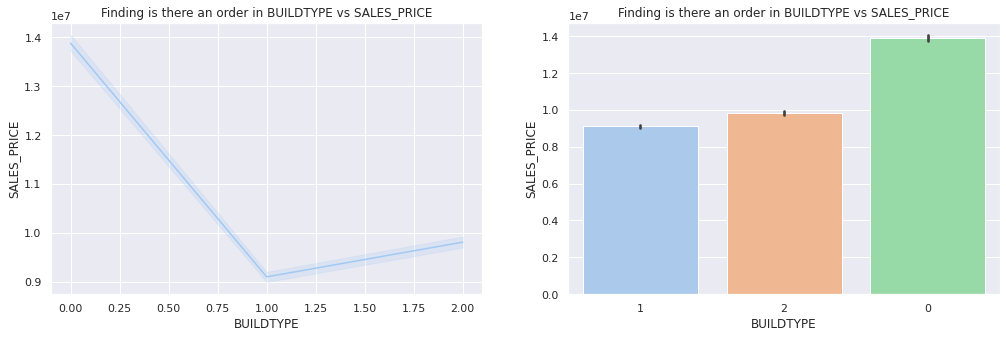

In [154]:
plt.figure(figsize=(17,5))
plt.subplot(121)
sns.lineplot(x=df['BUILDTYPE'],y=df['SALES_PRICE'])
plt.title('Finding is there an order in BUILDTYPE vs SALES_PRICE')
plt.subplot(122)
sns.barplot(x='BUILDTYPE',y='SALES_PRICE',data=df,order=df.groupby('BUILDTYPE')['SALES_PRICE'].mean().reset_index().sort_values('SALES_PRICE')['BUILDTYPE'])
plt.title('Finding is there an order in BUILDTYPE vs SALES_PRICE')
plt.show()

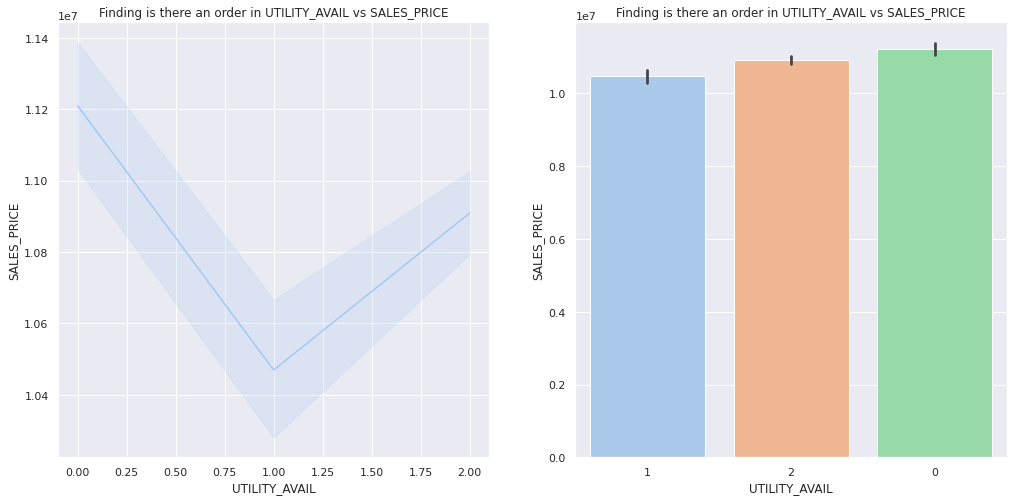

In [155]:
plt.figure(figsize=(17,8))
plt.subplot(121)
sns.lineplot(x=df['UTILITY_AVAIL'],y=df['SALES_PRICE'])
plt.title('Finding is there an order in UTILITY_AVAIL vs SALES_PRICE')
plt.subplot(122)
sns.barplot(x='UTILITY_AVAIL',y='SALES_PRICE',data=df,order=df.groupby('UTILITY_AVAIL')['SALES_PRICE'].mean().reset_index().sort_values('SALES_PRICE')['UTILITY_AVAIL'])
plt.title('Finding is there an order in UTILITY_AVAIL vs SALES_PRICE')
plt.show()

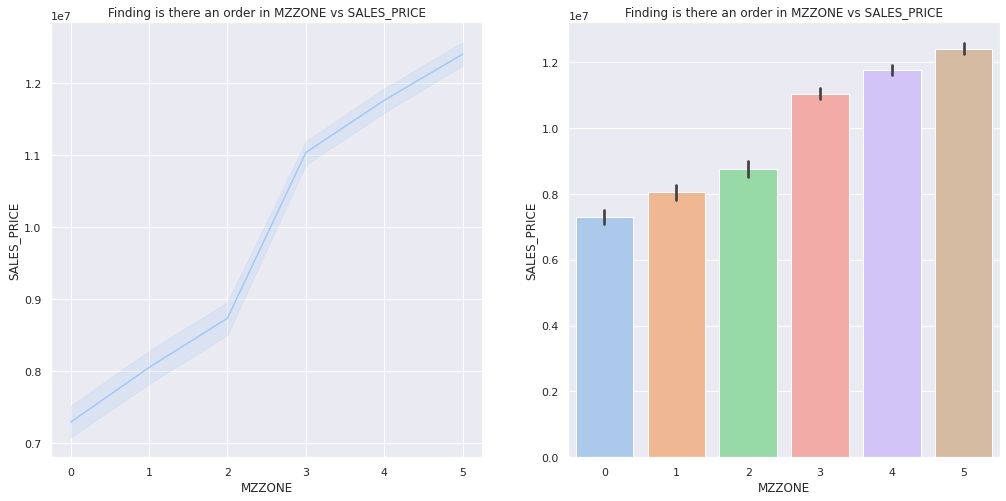

In [156]:
plt.figure(figsize=(17,8))
plt.subplot(121)
sns.lineplot(x=df['MZZONE'],y=df['SALES_PRICE'])
plt.title('Finding is there an order in MZZONE vs SALES_PRICE')
plt.subplot(122)
sns.barplot(x='MZZONE',y='SALES_PRICE',data=df,order=df.groupby('MZZONE')['SALES_PRICE'].mean().reset_index().sort_values('SALES_PRICE')['MZZONE'])
plt.title('Finding is there an order in MZZONE vs SALES_PRICE')
plt.show()

In above all the graphs there is an linear trend. For Encoding this categorical variable we use Label Encoding.

**REALTION WITH TARGET VARIABLE**

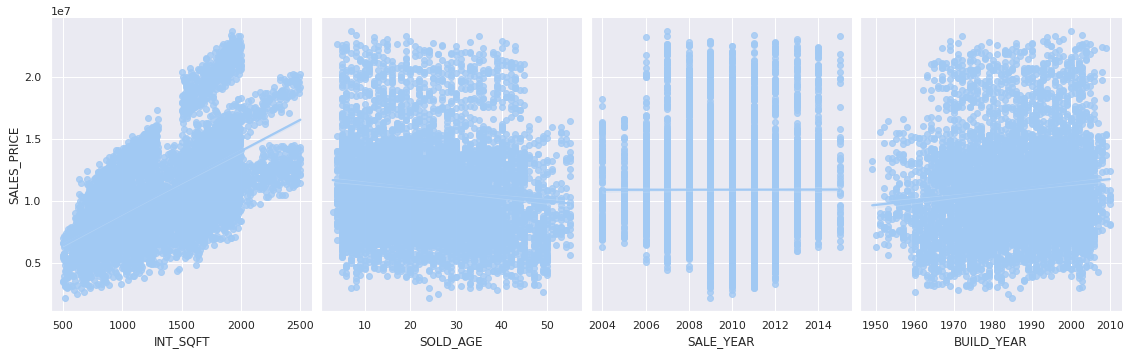

In [158]:
sns.pairplot(df,x_vars=["INT_SQFT", "SOLD_AGE","SALE_YEAR","BUILD_YEAR"], y_vars=["SALES_PRICE"],
             height=5,aspect=.8, kind="reg")
plt.show()

In above graph i have checked whether if there is a linear relationship with target_variable('SALES_PRICE').Only "INT_SQFT" has the clear linear relation with the target_variable('SALES_PRICE'), others are flatten.

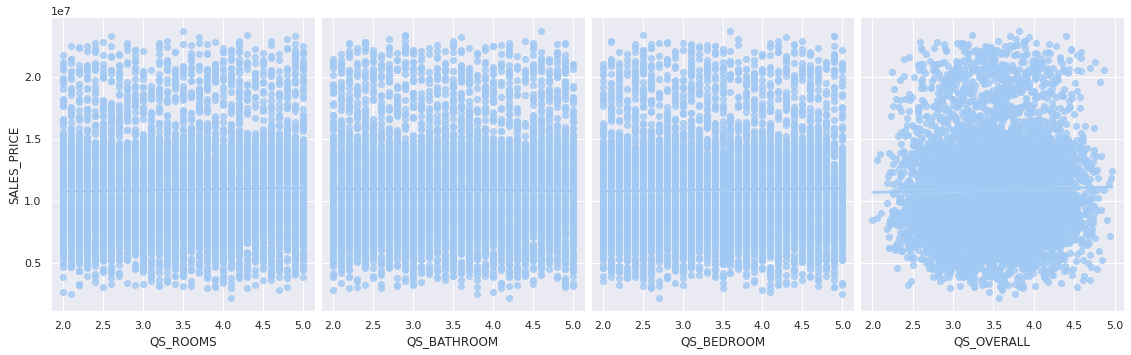

In [159]:
sns.pairplot(df,x_vars=["QS_ROOMS", "QS_BATHROOM","QS_BEDROOM","QS_OVERALL"], y_vars=["SALES_PRICE"],
             height=5, aspect=.8, kind="reg")
plt.show()

In above graph i have checked other few features has a linear relationship with target_variable('SALES_PRICE'). No features has the linear relationship with the target_variable('SALES_PRICE').

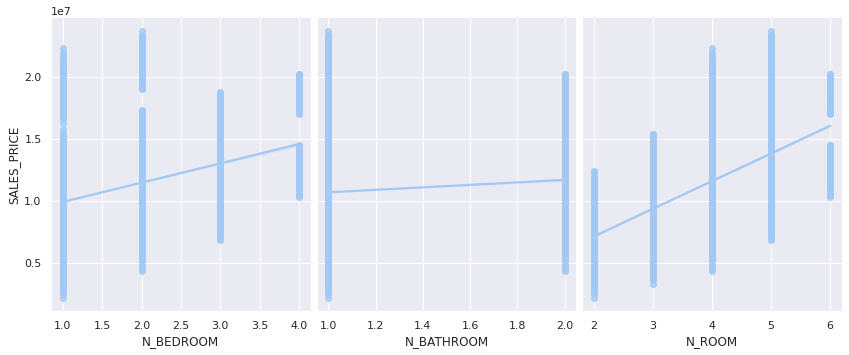

In [160]:
sns.pairplot(df,x_vars=["N_BEDROOM", "N_BATHROOM","N_ROOM"], y_vars=["SALES_PRICE"],
             height=5, aspect=.8, kind="reg")
plt.show()

In above graph i have checked other few features has a linear relationship with target_variable('SALES_PRICE'). ["N_ROOMS","N_BEDROOM"] has the linear relationship with the target_variable(SALES_PRICE). But "N_BATHROOM" has no linear relationship with the target_variable('SALES_PRICE').

In [161]:
buildtype_fltr_C = df['BUILDTYPE']=='Commercial'
commercial=df.loc[buildtype_fltr_C]
min = commercial['SALES_PRICE'].min()
mean= commercial['SALES_PRICE'].mean()
median = commercial['SALES_PRICE'].median()
max = commercial['SALES_PRICE'].max()
index=['Minimun_Sales_Price','Average_Sales_Price','Median_Sales_Price','Maximum_Sales_Price']
comm = pd.DataFrame([min,mean,median,max],columns=['Commercial'],index=index)

buildtype_fltr_H = df['BUILDTYPE']=='House'
House=df.loc[buildtype_fltr_H]
min = House['SALES_PRICE'].min()
mean= House['SALES_PRICE'].mean()
median = House['SALES_PRICE'].median()
max = House['SALES_PRICE'].max()
house = pd.DataFrame([min,mean,median,max],columns=['House'],index=index)

buildtype_fltr_O = df['BUILDTYPE']=='Others'
Others=df.loc[buildtype_fltr_O]
min = Others['SALES_PRICE'].min()
mean= Others['SALES_PRICE'].mean()
median = Others['SALES_PRICE'].median()
max = Others['SALES_PRICE'].max()
others = pd.DataFrame([min,mean,median,max],columns=['Others'],index=index)

Build_type_mmm = pd.concat([comm,house,others],axis=1)
Build_type_mmm = pd.DataFrame(Build_type_mmm.T)
Build_type_mmm["Build_type"]=["Commercial","House","Others"]


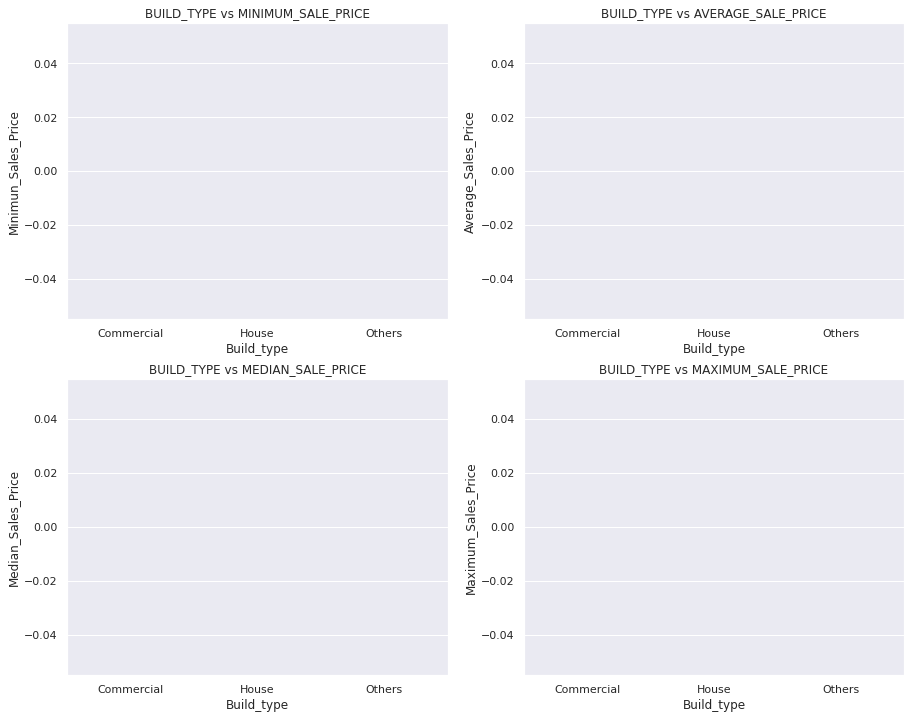

In [162]:
plt.figure(figsize=(15,12))
plt.subplot(221)
sns.barplot(x="Build_type",y="Minimun_Sales_Price",data=Build_type_mmm)
plt.title('BUILD_TYPE vs MINIMUM_SALE_PRICE')
plt.subplot(222)
sns.barplot(x="Build_type",y="Average_Sales_Price",data=Build_type_mmm)
plt.title('BUILD_TYPE vs AVERAGE_SALE_PRICE')
plt.subplot(223)
sns.barplot(x="Build_type",y="Median_Sales_Price",data=Build_type_mmm)
plt.title('BUILD_TYPE vs MEDIAN_SALE_PRICE')
plt.subplot(224)
sns.barplot(x="Build_type",y="Maximum_Sales_Price",data=Build_type_mmm)
plt.title('BUILD_TYPE vs MAXIMUM_SALE_PRICE')
plt.show()

**COMMERCIAL** - In all graphs, the Minimum,Average,Median and Maximum Price of commercial building is higher than "House" and "Others" building type.

**House** - Minimum price of "House" price is higher than "Others" building type, but Maximum,Average and Median Price lower than "Others" building type.

**Others** - Minimum price of "Others" price is lower than "House" building type, but Maximum,Average and Median Price higher than "House" building type.

In [163]:
mean=df.groupby('AREA')['SALES_PRICE'].mean()
mean_=mean.values
max=df.groupby('AREA')['SALES_PRICE'].max()
max_=max.values
min=df.groupby('AREA')['SALES_PRICE'].min()
min_=min.values
median=df.groupby('AREA')['SALES_PRICE'].median()
median_=min.values
Area_mmm=pd.DataFrame([min_,mean_,median_,max_],columns=mean.index,index=['Minimun_Sales_Price','Average_Sales_Price','Median_Sales_Price','Maximum_Sales_Price']).T
Area_mmm["AREA"]=["Adyar","Anna Nagar","Chrompet","KK Nagar","Karapakam","T Nagar","Velachery"]

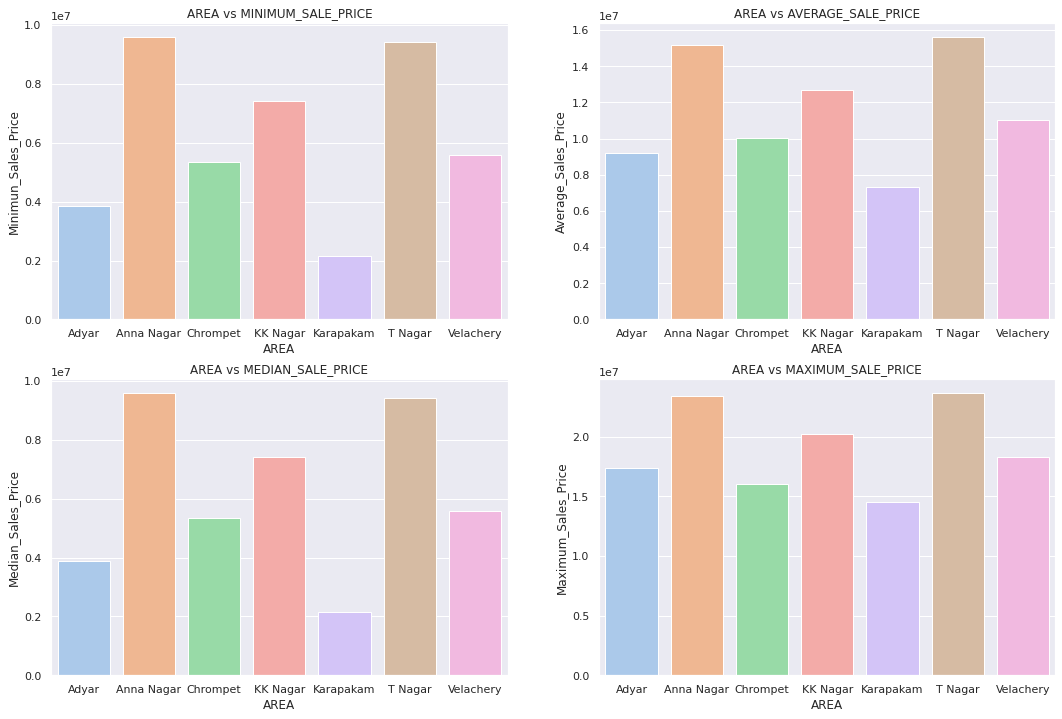

In [164]:
plt.figure(figsize=(18,12))
plt.subplot(221)
sns.barplot(x='AREA',y='Minimun_Sales_Price',data=Area_mmm)
plt.title('AREA vs MINIMUM_SALE_PRICE')
plt.subplot(222)
sns.barplot(x='AREA',y='Average_Sales_Price',data=Area_mmm)
plt.title('AREA vs AVERAGE_SALE_PRICE')
plt.subplot(223)
sns.barplot(x='AREA',y='Median_Sales_Price',data=Area_mmm)
plt.title('AREA vs MEDIAN_SALE_PRICE')
plt.subplot(224)
sns.barplot(x='AREA',y='Maximum_Sales_Price',data=Area_mmm)
plt.title('AREA vs MAXIMUM_SALE_PRICE')
plt.show()

In [165]:
mean=pd.DataFrame(df[['AREA', 'BUILDTYPE','SALES_PRICE']].groupby(['BUILDTYPE','AREA'])['SALES_PRICE'].mean())
median=pd.DataFrame(df[['AREA', 'BUILDTYPE','SALES_PRICE']].groupby(['BUILDTYPE','AREA'])['SALES_PRICE'].median())
max=pd.DataFrame(df[['AREA', 'BUILDTYPE','SALES_PRICE']].groupby(['BUILDTYPE','AREA'])['SALES_PRICE'].max())
min=pd.DataFrame(df[['AREA', 'BUILDTYPE','SALES_PRICE']].groupby(['BUILDTYPE','AREA'])['SALES_PRICE'].min())

In [166]:
mmm_df = pd.concat([min,mean['SALES_PRICE'].rename('Average'),median['SALES_PRICE'].rename('Median'),max['SALES_PRICE'].rename('Maximum')],axis=1)
column =['Minimum','Average','Median','Maximum']
mmm__df = pd.DataFrame(mmm_df)
mmm__df.rename(columns={'SALES_PRICE':'Minimum'},inplace=True)
mmm__df['BUILDTYPE']=['Commercial','Commercial','Commercial','Commercial','Commercial','Commercial','Commercial',
                      'House','House','House','House','House','House','House',
                      'Others','Others','Others','Others','Others','Others','Others']
mmm__df['AREA']=["Adyar","Anna Nagar","Chrompet","KK Nagar","Karapakam","T Nagar","Velachery",
                 "Adyar","Anna Nagar","Chrompet","KK Nagar","Karapakam","T Nagar","Velachery",
                 "Adyar","Anna Nagar","Chrompet","KK Nagar","Karapakam","T Nagar","Velachery"]

** RESPECTIVE WITH MINIMUM PRICE OF EACH AREA.**

**COMMERCIAL** - (LOW - HIGH) - Karapakkam area has the lowest price when compared with other area's. Followed with ["Adyar","Chrompet","Velachery","KK Nagar","Anna Nagar","T Nagar"]. "T Nagar" is the first highest according to the "Sales_Price".

**HOUSE** - (LOW - HIGH) - Again Karapakam area has the lowest price when compared with other area's. Followed with ["Adyar","Chrompet","Velachery","KK Nagar","Anna Nagar","T Nagar"]. Again "T Nagar" is the first highest according to the "Sales_Price".

**OTHERS** - (LOW - HIGH) - Again Karapakam area has the lowest price when compared with other area's. Followed with ["Adyar","Chrompet","Velachery","KK Nagar","Anna Nagar","T Nagar"]. Again "T Nagar" is the first highest according to the "Sales_Price".

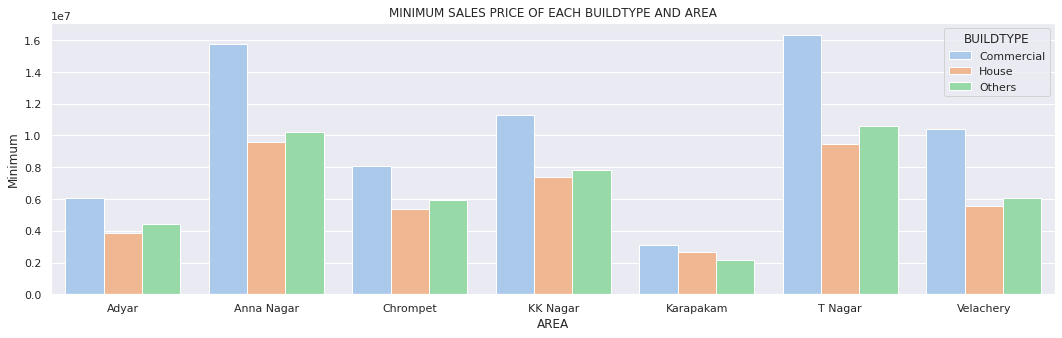

In [167]:
plt.figure(figsize=(18,5))
sns.barplot(x='AREA',y='Minimum',data=mmm__df,hue='BUILDTYPE')
plt.title('MINIMUM SALES PRICE OF EACH BUILDTYPE AND AREA')
plt.show()

**RESPECTIVE WITH AVERAGE PRICE OF EACH AREA.**

**COMMERCIAL** - (LOW - HIGH) - Karapakkam area has the lowest price when compared with other area's. Followed with ["Adyar","Chrompet","Velachery","KK Nagar","Anna Nagar","T Nagar"]. "T Nagar" is the first highest according to the "Sales_Price".

**HOUSE** - (LOW - HIGH) - Again Karapakam area has the lowest price when compared with other area's. Followed with ["Adyar","Chrompet","Velachery","KK Nagar""Anna Nagar","T Nagar"]. Again "T Nagar" is the first highest according to the "Sales_Price".

**OTHERS** - (LOW - HIGH) - Again Karapakam area has the lowest price when compared with other area's. Followed with ["Adyar","Chrompet","Velachery","KK Nagar","Anna Nagar","T Nagar"]. Again "T Nagar" is the first highest according to the "Sales_Price".

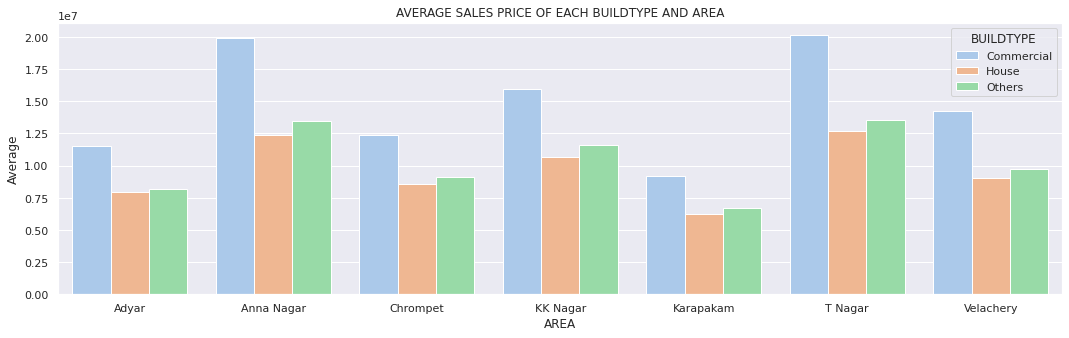

In [168]:
plt.figure(figsize=(18,5))
sns.barplot(x='AREA',y='Average',data=mmm__df,hue='BUILDTYPE')
plt.title('AVERAGE SALES PRICE OF EACH BUILDTYPE AND AREA')
plt.show()

** RESPECTIVE WITH MAXIMUM PRICE OF EACH AREA.**

**COMMERCIAL** - (LOW - HIGH) - Karapakkam area has the lowest price when compared with other area's. Followed with ["Chrompet","Adyar","Velachery","KK Nagar","Anna Nagar","T Nagar"]. "T Nagar" is the first highest according to the "Sales_Price".

**HOUSE** - (LOW - HIGH) - Again Karapakam area has the lowest price when compared with other area's. Followed with ["Adyar","Chrompet","Velachery","KK Nagar""Anna Nagar","T Nagar"]. Again "T Nagar" is the first highest according to the "Sales_Price".

**OTHERS** - (LOW - HIGH) - Again Karapakam area has the lowest price when compared with other area's. Followed with ["Adyar","Chrompet","Velachery","KK Nagar","Anna Nagar","T Nagar"]. Again "T Nagar" is the first highest according to the "Sales_Price".

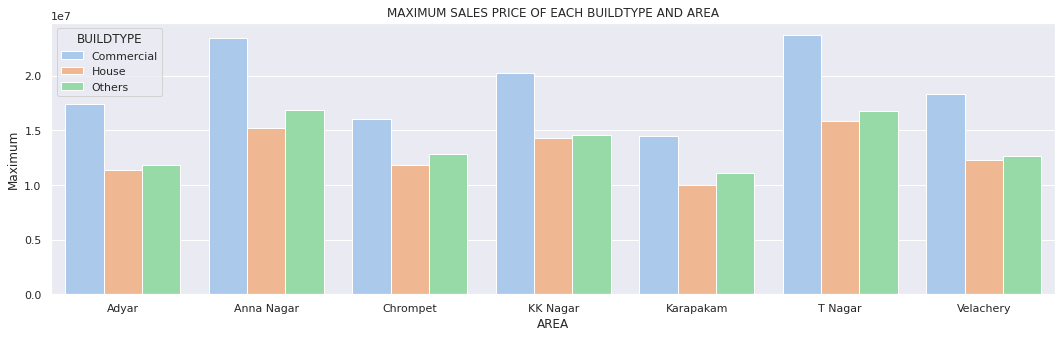

In [169]:
plt.figure(figsize=(18,5))
sns.barplot(x='AREA',y='Maximum',data=mmm__df,hue='BUILDTYPE')
plt.title('MAXIMUM SALES PRICE OF EACH BUILDTYPE AND AREA')
plt.show()

**ENCODING THE CATEGORICAL FEATURES**

In [170]:
df.head(2)

,AREA,INT_SQFT,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,SALE_COND,PARK_FACIL,BUILDTYPE,UTILITY_AVAIL,STREET,MZZONE,QS_ROOMS,QS_BATHROOM,QS_BEDROOM,QS_OVERALL,SALES_PRICE,BUILD_YEAR,SALE_YEAR,SOLD_AGE
0,4,1004,131,1.0,1.0,3,0,1,0,0,2,0,4.0,3.9,4.9,4.330,7600000,1967,2011,44
1,1,1986,26,2.0,1.0,5,0,0,0,0,0,3,4.9,4.2,2.5,3.765,21717770,1995,2006,11


In [171]:
pd.DataFrame(df.dtypes.value_counts()).T

,int64,float64
0,14,6


In [172]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

In [173]:
df['PARK_FACIL']=le.fit_transform(df['PARK_FACIL'])
df['AREA']=le.fit_transform(df['AREA'])
df['BUILDTYPE']=le.fit_transform(df['BUILDTYPE'])
df['SALE_COND']=le.fit_transform(df['SALE_COND'])
df['UTILITY_AVAIL']=le.fit_transform(df['UTILITY_AVAIL'])
df['STREET']=le.fit_transform(df['STREET'])
df['MZZONE']=le.fit_transform(df['MZZONE'])

In [174]:
df.head()

,AREA,INT_SQFT,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,SALE_COND,PARK_FACIL,BUILDTYPE,UTILITY_AVAIL,STREET,MZZONE,QS_ROOMS,QS_BATHROOM,QS_BEDROOM,QS_OVERALL,SALES_PRICE,BUILD_YEAR,SALE_YEAR,SOLD_AGE
0,4,1004,131,1.0,1.0,3,0,1,0,0,2,0,4.0,3.9,4.9,4.330,7600000,1967,2011,44
1,1,1986,26,2.0,1.0,5,0,0,0,0,0,3,4.9,4.2,2.5,3.765,21717770,1995,2006,11
2,0,909,70,1.0,1.0,3,0,1,0,1,0,4,4.1,3.8,2.2,3.090,13159200,1992,2012,20
3,6,1855,14,3.0,2.0,5,2,0,2,2,2,2,4.7,3.9,3.6,4.010,9630290,1988,2010,22
4,4,1226,84,1.0,1.0,3,0,1,2,0,0,1,3.0,2.5,4.1,3.290,7406250,1979,2009,30


**Feature importance**

Correlation with features

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


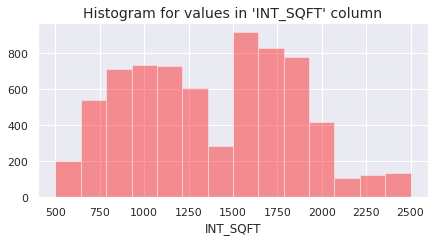

In [175]:
#histogram showing distribution of values in "INT_SQFT" columns
plt.figure(figsize=(7,3.2))
plt.title("Histogram for values in 'INT_SQFT' column",fontsize=14)
sns.distplot(df["INT_SQFT"],hist=True,kde=False,bins="sturges",color="red")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


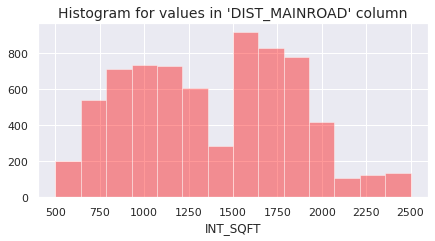

In [176]:
#histogram showing distribution of values in "DIST_MAINROAD" columns
plt.figure(figsize=(7,3.2))
plt.title("Histogram for values in 'DIST_MAINROAD' column",fontsize=14)
sns.distplot(df["INT_SQFT"],hist=True,kde=False,bins="sturges",color="red")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


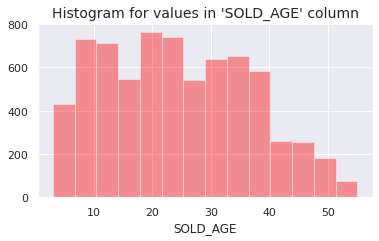

In [177]:
#histogram showing distribution of values in "SOLD_AGE" columns
plt.figure(figsize=(6,3.2))
plt.title("Histogram for values in 'SOLD_AGE' column",fontsize=14)
sns.distplot(df["SOLD_AGE"],hist=True,kde=False,bins="sturges",color="red")
plt.show()

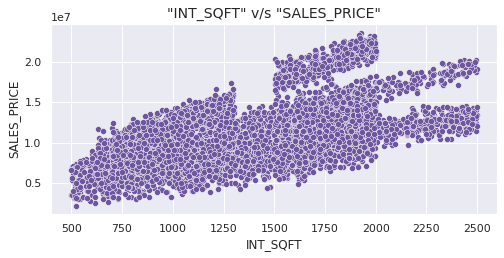

In [178]:
#scatter plot between "INT_SQFT" and "SALES_PRICE" columns
plt.figure(figsize=(8,3.5))
plt.title('"INT_SQFT" v/s "SALES_PRICE"',fontsize=14)
spl=sns.scatterplot(x="INT_SQFT",y="SALES_PRICE",data=df,color="#6d569e")
plt.show()

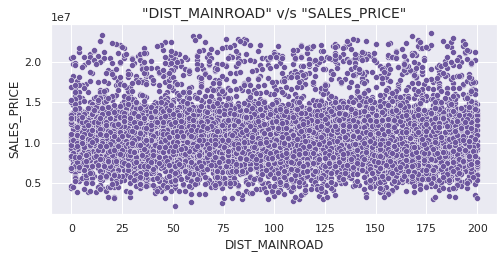

In [179]:
#scatter plot between "DIST_MAINROAD" and "SALES_PRICE" columns
plt.figure(figsize=(8,3.5))
plt.title('"DIST_MAINROAD" v/s "SALES_PRICE"',fontsize=14)
spl=sns.scatterplot(x="DIST_MAINROAD",y="SALES_PRICE",data=df,color="#6d569e")
plt.show()

Since "N_BEDROOM" is having discrete values we will make barplot as well

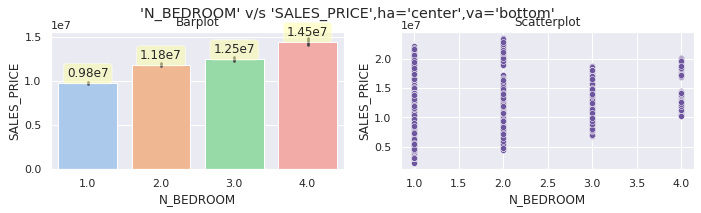

In [180]:
#barplot and scatterplot between "N_BEDROOM" and "SALES_PRICE" columns
fig=plt.figure(figsize=(10,3))
fig.suptitle("'N_BEDROOM' v/s 'SALES_PRICE',ha='center',va='bottom'")
#subplot 1:barplot
plt.subplot(121)
plt.title("Barplot",fontsize=12)
br8=sns.barplot(x="N_BEDROOM",y="SALES_PRICE",data=df)
for p in br8.patches:
  br8.annotate(str(round(p.get_height()/10**7,2))+"e7",
               xy=(p.get_x()+p.get_width()/2,p.get_height()+0.3*10**6),
               ha="center",va="bottom",
               bbox=dict(boxstyle="round",fc="y",alpha=0.5))
  
#subplot 2:scatterplot
plt.subplot(122)
plt.title("Scatterplot",fontsize=12)
sns.scatterplot(x="N_BEDROOM",y="SALES_PRICE",data=df,color="#6d569e")
plt.tight_layout()
plt.show()

Since "N_BEDROOM" is having discrete values we will make barplot as well

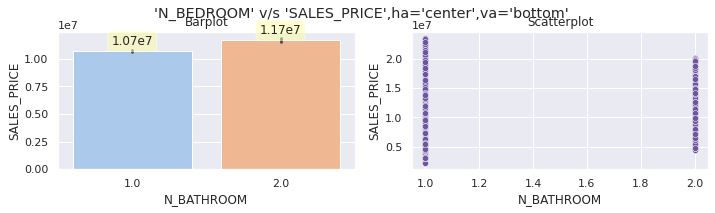

In [181]:
#barplot and scatterplot between "N_BATHROOM" and "SALES_PRICE" columns
fig=plt.figure(figsize=(10,3))
fig.suptitle("'N_BEDROOM' v/s 'SALES_PRICE',ha='center',va='bottom'")
#subplot 1:barplot
plt.subplot(121)
plt.title("Barplot",fontsize=12)
br8=sns.barplot(x="N_BATHROOM",y="SALES_PRICE",data=df)
for p in br8.patches:
  br8.annotate(str(round(p.get_height()/10**7,2))+"e7",
               xy=(p.get_x()+p.get_width()/2,p.get_height()+0.3*10**6),
               ha="center",va="bottom",
               bbox=dict(boxstyle="round",fc="y",alpha=0.5))
  
#subplot 2:scatterplot
plt.subplot(122)
plt.title("Scatterplot",fontsize=12)
sns.scatterplot(x="N_BATHROOM",y="SALES_PRICE",data=df,color="#6d569e")
plt.tight_layout()
plt.show()

In [182]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from scipy.stats import pearsonr

In [183]:
X=df.drop(['SALES_PRICE'],axis=1)
y=df['SALES_PRICE']

In [184]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5687, 19), (1422, 19), (5687,), (1422,))

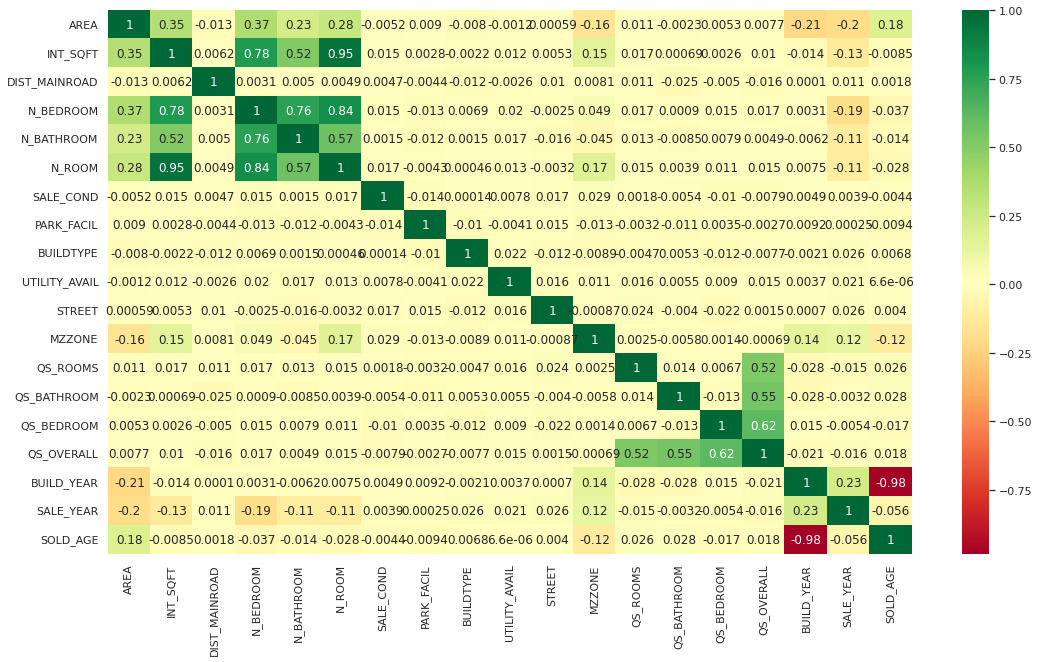

In [185]:
import seaborn as sns
#Using Pearson Correlation
plt.figure(figsize=(18,10))
cor = X_train.corr()
sns.heatmap(cor, annot=True,cmap='RdYlGn')
plt.show()

In [186]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are use absolute() to even focus on -ve coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [187]:
corr_features = correlation(X_train, 0.8)
len(set(corr_features))
print('This column are highly correlated with another column:',corr_features)

This column are highly correlated with another column: {'N_ROOM', 'SOLD_AGE'}


In [188]:
cwf_train=X_train.drop(corr_features,axis=1)
cwf_test=X_test.drop(corr_features,axis=1)

In [189]:
cwf_train.shape

(5687, 17)

In [190]:
train = pd.concat([cwf_train,y_train],axis=1)
test = pd.concat([cwf_test,y_test],axis=1)

In [191]:
new_df=pd.concat([train,test],axis=0)
new_df.shape
print("PREVIOUSLY THE NO. OF FEATURE IS:",df.shape)
print("NOW THE NO. OF FEATURE IS:",new_df.shape)
print("{} FEATURE IS BEEN REDUCED AFTER CORRELATION WITHIN INDEPENDENT FEATURES INCLUDING INF_PRICE".format(df.shape[1]-new_df.shape[1]))

PREVIOUSLY THE NO. OF FEATURE IS: (7109, 20)
NOW THE NO. OF FEATURE IS: (7109, 18)
2 FEATURE IS BEEN REDUCED AFTER CORRELATION WITHIN INDEPENDENT FEATURES INCLUDING INF_PRICE


correlation with target variable

,AREA,INT_SQFT,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,SALE_COND,PARK_FACIL,BUILDTYPE,UTILITY_AVAIL,STREET,MZZONE,QS_ROOMS,QS_BATHROOM,QS_BEDROOM,QS_OVERALL,BUILD_YEAR,SALE_YEAR,SALES_PRICE
SALES_PRICE,-0.019138,0.612125,0.018783,0.330987,0.108834,-0.030732,0.146428,-0.436276,-0.023812,-0.042652,0.427789,0.021967,-0.011377,0.018804,0.020485,0.116043,0.000906,1.0


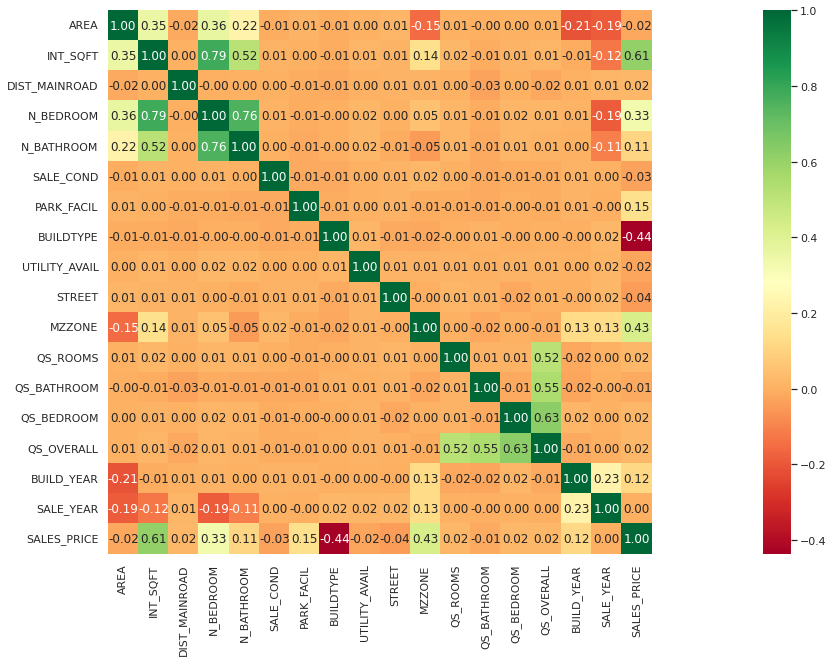

In [192]:
corrmat = new_df.corr()
plt.figure(figsize=(40, 10))
sns.heatmap(corrmat, cbar=True, fmt='.2f', annot=True, cmap='RdYlGn', square=True)
i=pd.DataFrame(new_df[new_df.columns[:]].corr()['SALES_PRICE'][:]).T
i=i.iloc[0]
pd.DataFrame(i).T

In [200]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from scipy.stats import pearsonr
scaler=StandardScaler()
minmax=MinMaxScaler()

In [201]:
X=new_df.drop(['SALES_PRICE'],axis=1)
y=new_df['SALES_PRICE']

In [202]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5687, 17), (1422, 17), (5687,), (1422,))

In [203]:
best_features_X = SelectKBest(score_func=f_regression,k=10).fit_transform(X,y)

In [204]:
correlation_list=[]
for column in X.columns:
  corr_list=pearsonr(X[column],y)
  correlation_list.append([column,corr_list[0],corr_list[1]])

In [205]:
corr_df=pd.DataFrame(correlation_list,columns=['Features','Correlation','P-Value'])
corr_df.sort_values(by='P-Value',inplace=True)
corr_df.T

,1,7,10,3,6,15,4,9,5,8,11,14,0,13,2,12,16
Features,INT_SQFT,BUILDTYPE,MZZONE,N_BEDROOM,PARK_FACIL,BUILD_YEAR,N_BATHROOM,STREET,SALE_COND,UTILITY_AVAIL,QS_ROOMS,QS_OVERALL,AREA,QS_BEDROOM,DIST_MAINROAD,QS_BATHROOM,SALE_YEAR
Correlation,0.612125,-0.436276,0.427789,0.330987,0.146428,0.116043,0.108834,-0.042652,-0.030732,-0.023812,0.021967,0.020485,-0.019138,0.018804,0.018783,-0.011377,0.000906
P-Value,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000322,0.00956,0.044681,0.064015,0.084155,0.106634,0.112895,0.113289,0.337486,0.939123


In [206]:
model_training_feature1 = corr_df['Features']
model_training_feature1 = model_training_feature1.to_list()
model_training_feature = corr_df['Features']
model_training_feature = model_training_feature.to_list()
model_training_feature

['INT_SQFT',
 'BUILDTYPE',
 'MZZONE',
 'N_BEDROOM',
 'PARK_FACIL',
 'BUILD_YEAR',
 'N_BATHROOM',
 'STREET',
 'SALE_COND',
 'UTILITY_AVAIL',
 'QS_ROOMS',
 'QS_OVERALL',
 'AREA',
 'QS_BEDROOM',
 'DIST_MAINROAD',
 'QS_BATHROOM',
 'SALE_YEAR']

In [207]:
new_df = pd.DataFrame(new_df,columns=model_training_feature)
new_df=pd.concat([new_df,df['SALES_PRICE']],axis=1)

In [208]:
new_df.head(2)

,INT_SQFT,BUILDTYPE,MZZONE,N_BEDROOM,PARK_FACIL,BUILD_YEAR,N_BATHROOM,STREET,SALE_COND,UTILITY_AVAIL,QS_ROOMS,QS_OVERALL,AREA,QS_BEDROOM,DIST_MAINROAD,QS_BATHROOM,SALE_YEAR,SALES_PRICE
0,1004,0,0,1.0,1,1967,1.0,2,0,0,4.0,4.330,4,4.9,131,3.9,2011,7600000
1,1986,0,3,2.0,0,1995,1.0,0,0,0,4.9,3.765,1,2.5,26,4.2,2006,21717770


In [209]:
df=new_df

In [210]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
scaler=StandardScaler()
minmax=MinMaxScaler()

In [211]:
X=new_df.drop('SALES_PRICE',axis=1)
y=df['SALES_PRICE']

In [212]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5687, 17), (1422, 17), (5687,), (1422,))

In [213]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

With cross validation

In [214]:
from sklearn.model_selection import cross_val_score

In [215]:
from sklearn.linear_model import LinearRegression
lr_model=LinearRegression()
import xgboost as xg
# xg_model = XGBRegressor()
xg_model= xg.XGBRegressor(colsample_bytree=0.4,
                 gamma=2,                 
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                ) 
rf = RandomForestRegressor(n_estimators= 1000, max_depth = 4, max_features='sqrt')

In [220]:
CV_Linear_regression = cross_val_score(lr_model,X_train_scaled,y_train,cv=10).mean()
print("The cross_validation score of an Linear_Regression model is:",CV_Linear_regression)

The cross_validation score of an Linear_Regression model is: 0.7796645250756351


In [221]:
CV_RandomForest = cross_val_score(rf,X_train_scaled,y_train,cv=10).mean()
print("The cross_validation score of an XG_Boost model is:",CV_RandomForest)

The cross_validation score of an XG_Boost model is: 0.7807950413218127


In [224]:
print("The cross_validation score of an Linear_Regression model is:",CV_Linear_regression)
print("The cross_validation score of an Random_Forest model is:",CV_RandomForest)

The cross_validation score of an Linear_Regression model is: 0.7796645250756351
The cross_validation score of an Random_Forest model is: 0.7807950413218127


R_SQUARED_SCORES.

The cross_validation score of an Linear_Regression model is : 0.7796645250756351

The cross_validation score of an Random_Forest model is : 0.7807950413218127

**WITHOUT CROSS_VALIDATION**

1st MODEL IS LINEAR REGRESSION

In [225]:
from sklearn.linear_model import LinearRegression
lr_model=LinearRegression()

In [226]:
lr_model.fit(X_train,y_train)

LinearRegression()

In [227]:
lr_y_pred=lr_model.predict(X_test)

In [228]:
print(r2_score(y_test,lr_y_pred))

0.7738853444225784


2nd MODEL IS RANDOM FOREST

In [234]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate model 
rf = RandomForestRegressor(n_estimators= 1000, max_depth = 4, max_features='sqrt')

# Train the model on training data
rf.fit(X_train, y_train);

# Use the forest's predict method on the test data
rf_pred = rf.predict(X_test)

In [235]:
print("Random forest Regressor model Rsquared metric",r2_score(y_test,rf_pred))

Random forest Regressor model Rsquared metric 0.7758060194278309


3rd MODEL IS ENSEMBLE TECHNIQUE

In [236]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xg

model1 = LinearRegression()
model2 = RandomForestRegressor(random_state=1)
model3 = GradientBoostingRegressor(random_state=1)
model4 = DecisionTreeRegressor(random_state=1)
# model4 = xg.XGBRegressor(random_state=1) 
# # we need to give the list of models that we are trying to combine
# model.fit(x_train,y_train) # to train all of the models
# preds = model.predict(x_test)
# model.score(x_test,y_test) # prediction

# model = VotingRegressor(estimators=[('Linear_Regg', model1), ('Random_Forest', model2), ('Gradient_Boosting', model3),('Decision_Tree',model4)])
model = VotingRegressor(estimators=[('Linear_Regg', model1), ('Random_Forest', model2), ('Gradient_Boosting', model3)])
model.fit(X_train,y_train)
et_y_pred=model.predict(X_test)
print("Ensemble Technique Rsquared metric",r2_score(y_test,et_y_pred))

Ensemble Technique Rsquared metric 0.9580878321766352


R_SQUARED_SCORES.

The cross_validation score of an Linear_Regression model is : 0.7738853444225784

The cross_validation score of an Random_Forest model is : 0.7758060194278309

The cross_validation score of an Ensemble_technic model is : 0.9580878321766352

BEST MODEL:

My Ensemble technique model give me the high accuracy which is close to 1.

Followed by RandomForest Regressor and Linear Regression.

In [238]:
print("Ensemble Technique Rsquared metric:",r2_score(y_test,et_y_pred))
print("Random forest Regressor model Rsquared metric:",r2_score(y_test,rf_pred))
print("Linear Regg model Rsquared metric:",r2_score(y_test,lr_y_pred))

Ensemble Technique Rsquared metric: 0.9580878321766352
Random forest Regressor model Rsquared metric: 0.7758060194278309
Linear Regg model Rsquared metric: 0.7738853444225784
